# Car Type Classification - Assignment

## System Information
- **Development Environment**: WSL2 Ubuntu on Windows
- **Python Version**: 3.12
- **TensorFlow Version**: 2.19.0 with GPU support
- **Platform**: Linux (WSL2) - Recommended for optimal performance

## Setup Notes
This notebook was developed and tested on WSL2 Ubuntu for the best TensorFlow performance with GPU acceleration. For setup instructions for different platforms (Windows native, Linux, WSL2), please refer to the README.md file.

---

# 1. Environment Setup

## Objective
Set up a Python environment with all necessary dependencies to support data processing, model training, and API development.

**Thought process: To ensure efficient training, especially for large datasets like Stanford Cars, we need GPU acceleration. WSL2 on Windows is chosen for its Linux environment, optimal for TensorFlow 2.19.0 with GPU support. We'll verify TensorFlow version and GPU availability to confirm setup, using libraries like NumPy for data handling and ensuring reproducibility with random seeds.**

## Steps

**System Environment**: This notebook is being run on WSL2 Ubuntu, which provides optimal performance for TensorFlow with GPU acceleration support.

**Python Version**: Python 3.12 is used to ensure compatibility with TensorFlow 2.19.0 and FastAPI.

**Framework Choice**: The assessment allows TensorFlow 2.x (Keras) or PyTorch. This implementation uses TensorFlow 2.19.0 with Keras for its robust integration with pre-trained models and excellent GPU support on Linux/WSL2.

**Dependencies**: All required libraries are installed via the requirements.txt file optimized for Linux/WSL2. For platform-specific installation instructions, refer to README.md.

**GPU Support**: This setup leverages CUDA acceleration when available, significantly improving training performance compared to CPU-only execution.

### GPU Setup (Optional but Recommended)

For optimal performance with GPU acceleration, follow `gpu_setup_guide.ipynb`.

In [1]:
# Main imports for Car Classification Project
import os

# Configure TensorFlow environment before importing TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN warnings
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'  # Better GPU memory management

import platform
import numpy as np
import tensorflow as tf

# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

print("🚀 Car Classification Environment")
print("=" * 40)
print(f"TensorFlow version: {tf.__version__}")
print(f"Operating System: {platform.system()}")
print(f"Architecture: {platform.machine()}")

# Check for GPU availability (OS-dependent)
system = platform.system().lower()

if system == 'windows':
    print("🪟 Windows detected: Running in CPU-only mode")
    print("💡 For GPU support on Windows, consider using WSL2 or Docker")
    print("🚀 Your RTX 4060 can still be used via WSL2 if needed")
    
elif system == 'linux':
    print("🐧 Linux detected: Checking for GPU support...")
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU devices detected: {len(gpus)}")
    
    if gpus:
        print("🎉 GPU DETECTED!")
        for i, gpu in enumerate(gpus):
            print(f"  🎮 GPU {i}: {gpu}")
        
        # Configure GPU memory growth to prevent allocation errors
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU memory growth enabled")
        except RuntimeError:
            print("⚠️ GPU memory growth already configured")
        
        # Enable mixed precision for better performance
        try:
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("✅ Mixed precision enabled for optimal GPU performance")
        except Exception as e:
            print(f"⚠️ Mixed precision setup: {e}")
    else:
        print("⚠️ No GPU detected - using CPU")
        print("💡 For GPU setup, run the troubleshooting cell below")
        
elif system == 'darwin':
    print("🍎 macOS detected: Optimized for Apple hardware")
    if 'arm' in platform.machine().lower():
        print("🚀 Apple Silicon detected: Using optimized Metal Performance Shaders")
    else:
        print("💻 Intel Mac: CPU-only mode")

# CPU optimizations for all platforms
print("⚡ Enabling CPU optimizations...")
tf.config.threading.set_inter_op_parallelism_threads(0)  # Use all available cores
tf.config.threading.set_intra_op_parallelism_threads(0)  # Use all available cores

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Environment ready for car classification training!")
print("📊 Performance optimized for your hardware configuration")

2025-07-24 23:02:12.941965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753369332.950123    2409 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753369332.952729    2409 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753369332.959417    2409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753369332.959429    2409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753369332.959430    2409 computation_placer.cc:177] computation placer alr

🚀 Car Classification Environment
TensorFlow version: 2.19.0
Operating System: Linux
Architecture: x86_64
🐧 Linux detected: Checking for GPU support...
GPU devices detected: 1
🎉 GPU DETECTED!
  🎮 GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ GPU memory growth enabled
✅ Mixed precision enabled for optimal GPU performance
⚡ Enabling CPU optimizations...
✅ Environment ready for car classification training!
📊 Performance optimized for your hardware configuration


# 2. Data Loading and Preprocessing

## Objective
Prepare the Stanford Cars Dataset for training by downloading, preprocessing, and splitting it into appropriate sets.

**Thought Process: The Stanford Cars Dataset has 196 classes, requiring robust preprocessing. We'll download via KaggleHub for reliability, resize to 224x224 for ResNet50, normalize pixels for consistency, and use augmentation to handle variations. Splitting into train/validation/test sets, with 20% validation from training, ensures proper evaluation.**

## Dataset Details
Source: The Stanford Cars Dataset contains 16,185 images across 196 classes (Make, Model, Year), with 8,144 training and 8,041 testing images. Images are approximately 360x240 pixels.

Download: Access the dataset from Kaggle or the official site (note: the official URL seems to be broken, so I'll download from Kaggle).

Structure: The dataset includes images and annotations in .mat format, requiring scipy to load.

## Preprocessing Steps
Resize Images: Resize images to 224x224 pixels to match the input size of pre-trained models like ResNet50.

Normalization: Scale pixel values to [0, 1] by dividing by 255.

Augmentation: Apply random flips, rotations, and color jitter to improve model generalization.

Data Splitting: Use the provided train/test split. Create a validation set by taking 20% of the training data (approximately 1,629 images).

In [2]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("cyizhuo/stanford-cars-by-classes-folder")

print("Path to dataset files:", download_path)

Path to dataset files: /home/alph/.cache/kagglehub/datasets/cyizhuo/stanford-cars-by-classes-folder/versions/5


In [3]:
# 🔍 Robust Dataset Structure Detection and Organization

import shutil
from pathlib import Path

def detect_dataset_structure(downloaded_path):
    """
    Robustly detect and analyze the Stanford Cars dataset folder structure
    Handles multiple possible formats from different sources
    """
    
    print("🔍 DETECTING DATASET STRUCTURE...")
    print("=" * 50)
    
    # Check all possible locations where dataset might be
    possible_paths = [
        Path(downloaded_path),
        Path("data"),
        Path("."),
        Path("stanford-cars-by-classes-folder"),
        Path("~/.cache/kagglehub").expanduser(),
    ]
    
    dataset_info = {
        'found': False,
        'location': None,
        'structure_type': None,
        'train_path': None,
        'test_path': None,
        'classes': [],
        'total_images': 0
    }
    
    for base_path in possible_paths:
        if not base_path.exists():
            continue
            
        print(f"🔍 Checking: {base_path.absolute()}")
        
        # Look for different possible structures
        structures_to_check = [
            # Structure 1: Direct train/test folders
            {'train': base_path / 'train', 'test': base_path / 'test', 'type': 'direct_train_test'},
            {'train': base_path / 'cars_train', 'test': base_path / 'cars_test', 'type': 'cars_prefix'},
            
            # Structure 2: Nested in subdirectories
            {'train': base_path / 'stanford-cars-dataset' / 'train', 'test': base_path / 'stanford-cars-dataset' / 'test', 'type': 'nested_stanford'},
            {'train': base_path / 'stanford-cars-by-classes-folder' / 'train', 'test': base_path / 'stanford-cars-by-classes-folder' / 'test', 'type': 'nested_classes'},
            
            # Structure 3: Single folder with all classes (need to split)
            {'train': base_path / 'all_classes', 'test': None, 'type': 'single_folder'},
            
            # Structure 4: Kagglehub cache structure
            {'train': None, 'test': None, 'type': 'kagglehub_cache'},
        ]
        
        for structure in structures_to_check:
            if structure['type'] == 'kagglehub_cache':
                # Special handling for kagglehub cache
                if 'kagglehub' in str(base_path):
                    for item in base_path.rglob('*'):
                        if item.is_dir() and ('train' in item.name.lower() or 'test' in item.name.lower()):
                            print(f"   📁 Found kagglehub folder: {item}")
                            dataset_info['found'] = True
                            dataset_info['location'] = base_path
                            dataset_info['structure_type'] = 'kagglehub_cache'
                            break
                continue
            
            train_path = structure['train']
            test_path = structure['test']
            
            # Check if this structure exists
            train_exists = train_path and train_path.exists() and train_path.is_dir()
            test_exists = test_path and test_path.exists() and test_path.is_dir()
            
            if train_exists or test_exists:
                print(f"   ✅ Found structure type: {structure['type']}")
                print(f"   📁 Train folder: {train_path} ({'✅' if train_exists else '❌'})")
                print(f"   📁 Test folder: {test_path} ({'✅' if test_exists else '❌'})")
                
                # Analyze the structure
                classes = []
                total_images = 0
                
                if train_exists:
                    classes = [d.name for d in train_path.iterdir() if d.is_dir()]
                    for class_dir in train_path.iterdir():
                        if class_dir.is_dir():
                            image_count = len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
                            total_images += image_count
                
                dataset_info.update({
                    'found': True,
                    'location': base_path,
                    'structure_type': structure['type'],
                    'train_path': train_path if train_exists else None,
                    'test_path': test_path if test_exists else None,
                    'classes': classes[:10],  # Show first 10 classes
                    'total_images': total_images
                })
                
                print(f"   📊 Classes found: {len(classes)} (showing first 10)")
                for i, class_name in enumerate(classes[:10]):
                    print(f"      {i+1:2d}. {class_name}")
                if len(classes) > 10:
                    print(f"      ... and {len(classes) - 10} more classes")
                print(f"   🖼️ Total training images: {total_images}")
                
                return dataset_info
    
    print("❌ No Stanford Cars dataset found in any expected location")
    return dataset_info

def organize_dataset_structure(dataset_info):
    """
    Organize the dataset into a standard structure for training
    """
    
    if not dataset_info['found']:
        print("❌ Cannot organize dataset - no dataset found")
        return None
    
    print(f"\n🔧 ORGANIZING DATASET STRUCTURE...")
    print("=" * 50)
    
    # Create standard data directory structure
    standard_data_dir = Path("data")
    standard_train_dir = standard_data_dir / "train"
    standard_test_dir = standard_data_dir / "test"
    
    standard_data_dir.mkdir(exist_ok=True)
    standard_train_dir.mkdir(exist_ok=True)
    standard_test_dir.mkdir(exist_ok=True)
    
    structure_type = dataset_info['structure_type']
    
    if structure_type in ['direct_train_test', 'cars_prefix', 'nested_stanford', 'nested_classes']:
        # Copy/link existing train and test folders
        
        if dataset_info['train_path'] and dataset_info['train_path'].exists():
            print(f"📁 Organizing training data from: {dataset_info['train_path']}")
            
            if not any(standard_train_dir.iterdir()):  # Only copy if empty
                for class_dir in dataset_info['train_path'].iterdir():
                    if class_dir.is_dir():
                        dest_class_dir = standard_train_dir / class_dir.name
                        if not dest_class_dir.exists():
                            print(f"   📂 Copying class: {class_dir.name}")
                            shutil.copytree(class_dir, dest_class_dir)
            else:
                print("   ✅ Training data already organized")
        
        if dataset_info['test_path'] and dataset_info['test_path'].exists():
            print(f"📁 Organizing test data from: {dataset_info['test_path']}")
            
            if not any(standard_test_dir.iterdir()):  # Only copy if empty
                for class_dir in dataset_info['test_path'].iterdir():
                    if class_dir.is_dir():
                        dest_class_dir = standard_test_dir / class_dir.name
                        if not dest_class_dir.exists():
                            print(f"   📂 Copying class: {class_dir.name}")
                            shutil.copytree(class_dir, dest_class_dir)
            else:
                print("   ✅ Test data already organized")
    
    elif structure_type == 'single_folder':
        # Split single folder into train/test (80/20 split)
        print("📁 Splitting single folder into train/test sets...")
        
        source_path = dataset_info['location']
        # Implementation for splitting would go here
        print("⚠️ Single folder splitting not yet implemented - please organize manually")
    
    elif structure_type == 'kagglehub_cache':
        print("📁 Detecting kagglehub cache structure...")
        # Find the actual dataset files in kagglehub cache
        cache_path = dataset_info['location']
        
        # Look for train/test folders in cache
        for item in cache_path.rglob('*'):
            if item.is_dir() and 'train' in item.name.lower():
                print(f"   📂 Found train folder: {item}")
                dataset_info['train_path'] = item
            elif item.is_dir() and 'test' in item.name.lower():
                print(f"   📂 Found test folder: {item}")
                dataset_info['test_path'] = item
        
        # Recursive call with updated paths
        return organize_dataset_structure(dataset_info)
    
    # Verify final structure
    train_classes = [d.name for d in standard_train_dir.iterdir() if d.is_dir()]
    test_classes = [d.name for d in standard_test_dir.iterdir() if d.is_dir()]
    
    print(f"\n✅ DATASET ORGANIZATION COMPLETE!")
    print(f"📊 Training classes: {len(train_classes)}")
    print(f"📊 Test classes: {len(test_classes)}")
    
    # Count images
    total_train_images = sum(len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]) 
                           for class_dir in standard_train_dir.iterdir() if class_dir.is_dir())
    total_test_images = sum(len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]) 
                          for class_dir in standard_test_dir.iterdir() if class_dir.is_dir())
    
    print(f"🖼️ Training images: {total_train_images}")
    print(f"🖼️ Test images: {total_test_images}")
    
    return {
        'train_dir': standard_train_dir,
        'test_dir': standard_test_dir,
        'train_classes': train_classes,
        'test_classes': test_classes,
        'train_images': total_train_images,
        'test_images': total_test_images
    }

def verify_dataset_compatibility():
    """
    Verify that the organized dataset is compatible with Keras ImageDataGenerator
    """
    
    print(f"\n🔍 VERIFYING DATASET COMPATIBILITY...")
    print("=" * 50)
    
    data_dir = Path("data")
    train_dir = data_dir / "train"
    test_dir = data_dir / "test"
    
    issues = []
    
    # Check basic structure
    if not train_dir.exists():
        issues.append("❌ Train directory missing")
    else:
        print("✅ Train directory found")
    
    if not test_dir.exists():
        issues.append("⚠️ Test directory missing (optional)")
    else:
        print("✅ Test directory found")
    
    # Check class structure
    if train_dir.exists():
        train_classes = [d for d in train_dir.iterdir() if d.is_dir()]
        if len(train_classes) == 0:
            issues.append("❌ No class folders found in train directory")
        else:
            print(f"✅ Found {len(train_classes)} training classes")
            
            # Check if classes have images
            empty_classes = []
            for class_dir in train_classes:
                image_files = [f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
                if len(image_files) == 0:
                    empty_classes.append(class_dir.name)
            
            if empty_classes:
                issues.append(f"⚠️ Empty classes found: {', '.join(empty_classes[:5])}")
            else:
                print("✅ All classes contain images")
    
    # Check file formats
    if train_dir.exists():
        all_files = list(train_dir.rglob('*'))
        image_files = [f for f in all_files if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        other_files = [f for f in all_files if f.is_file() and f.suffix.lower() not in ['.jpg', '.jpeg', '.png']]
        
        print(f"📊 Image files: {len(image_files)}")
        if other_files:
            print(f"⚠️ Non-image files: {len(other_files)} (first 5: {[f.name for f in other_files[:5]]})")
    
    # Summary
    if issues:
        print(f"\n⚠️ ISSUES FOUND:")
        for issue in issues:
            print(f"   {issue}")
        print("\n💡 You may need to manually fix these issues before training")
    else:
        print(f"\n✅ DATASET READY FOR TRAINING!")
        print("🚀 All checks passed - dataset is compatible with ImageDataGenerator")
    
    return len(issues) == 0

# 🚀 Execute Dataset Detection and Organization

print("🎯 STANFORD CARS DATASET DETECTION AND ORGANIZATION")
print("=" * 60)

# Step 1: Detect dataset structure
dataset_info = detect_dataset_structure(download_path)

if dataset_info['found']:
    print(f"\n🎉 Dataset found!")
    print(f"📍 Location: {dataset_info['location']}")
    print(f"🏗️ Structure type: {dataset_info['structure_type']}")
    
    # Step 2: Organize dataset
    organized_info = organize_dataset_structure(dataset_info)
    
    if organized_info:
        # Step 3: Verify compatibility
        is_compatible = verify_dataset_compatibility()
        
        if is_compatible:
            print(f"\n🎯 DATASET SETUP SUCCESSFUL!")
            print("✅ Ready to proceed with model training")
            
            # Store for later use
            DATASET_READY = True
            TRAIN_DIR = organized_info['train_dir']
            TEST_DIR = organized_info['test_dir']
            NUM_CLASSES = len(organized_info['train_classes'])
            
            print(f"📊 Configuration:")
            print(f"   Train directory: {TRAIN_DIR}")
            print(f"   Test directory: {TEST_DIR}")
            print(f"   Number of classes: {NUM_CLASSES}")
        else:
            print(f"\n⚠️ Dataset has issues - may need manual fixing")
            DATASET_READY = False
    else:
        print(f"\n❌ Failed to organize dataset")
        DATASET_READY = False
else:
    print(f"\n📥 No dataset found. Options:")
    print("1. Run the previous cell to download via kagglehub")
    print("2. Download manually and place in 'data' folder")
    print("3. Continue with demo data for testing")
    DATASET_READY = False

print("\n" + "=" * 60)

🎯 STANFORD CARS DATASET DETECTION AND ORGANIZATION
🔍 DETECTING DATASET STRUCTURE...
🔍 Checking: /home/alph/.cache/kagglehub/datasets/cyizhuo/stanford-cars-by-classes-folder/versions/5
   ✅ Found structure type: direct_train_test
   📁 Train folder: /home/alph/.cache/kagglehub/datasets/cyizhuo/stanford-cars-by-classes-folder/versions/5/train (✅)
   📁 Test folder: /home/alph/.cache/kagglehub/datasets/cyizhuo/stanford-cars-by-classes-folder/versions/5/test (✅)
   📊 Classes found: 196 (showing first 10)
       1. Jeep Liberty SUV 2012
       2. Maybach Landaulet Convertible 2012
       3. Audi V8 Sedan 1994
       4. Mercedes-Benz C-Class Sedan 2012
       5. BMW M5 Sedan 2010
       6. Ford Mustang Convertible 2007
       7. BMW ActiveHybrid 5 Sedan 2012
       8. Acura TL Type-S 2008
       9. HUMMER H2 SUT Crew Cab 2009
      10. BMW M3 Coupe 2012
      ... and 186 more classes
   🖼️ Total training images: 8144

🎉 Dataset found!
📍 Location: /home/alph/.cache/kagglehub/datasets/cyizhuo/st

In [4]:
def load_stanford_cars_metadata():
    """
    Load Stanford Cars dataset metadata and class information
    """
    print("\n📊 Loading Stanford Cars Dataset Metadata...")
    
    # Stanford Cars class names (196 classes)
    car_classes = [
        "AM General Hummer SUV 2000", "Acura RL Sedan 2012", "Acura TL Sedan 2012", 
        "Acura TL Type-S 2008", "Acura TSX Sedan 2012", "Acura Integra Type R 2001",
        "Acura ZDX Hatchback 2012", "Aston Martin V8 Vantage Convertible 2012",
        "Aston Martin V8 Vantage Coupe 2012", "Aston Martin Virage Convertible 2012",
        "Aston Martin Virage Coupe 2012", "Audi RS 4 Convertible 2008",
        "Audi A5 Coupe 2012", "Audi TTS Coupe 2012", "Audi R8 Coupe 2012",
        "Audi V8 Sedan 1994", "Audi 100 Sedan 1994", "Audi 100 Wagon 1994",
        "Audi TT Hatchback 2011", "Audi S6 Sedan 2011", "Audi S5 Convertible 2012",
        "Audi S5 Coupe 2012", "Audi S4 Sedan 2007", "Audi S4 Sedan 2012",
        "Audi TT RS Coupe 2012", "BMW ActiveHybrid 5 Sedan 2012", "BMW 1 Series Convertible 2012",
        "BMW 1 Series Coupe 2012", "BMW 3 Series Sedan 2012", "BMW 3 Series Wagon 2012",
        "BMW 6 Series Convertible 2007", "BMW X5 SUV 2007", "BMW X6 SUV 2012",
        "BMW M3 Coupe 2012", "BMW M5 Sedan 2010", "BMW M6 Convertible 2010",
        "BMW X3 SUV 2012", "BMW Z4 Convertible 2012", "Bentley Continental Supersports Conv. Convertible 2012",
        "Bentley Arnage Sedan 2009", "Bentley Mulsanne Sedan 2011", "Bentley Continental GT Coupe 2007",
        "Bentley Continental GT Coupe 2012", "Bentley Continental Flying Spur Sedan 2007",
        "Bugatti Veyron 16.4 Convertible 2009", "Bugatti Veyron 16.4 Coupe 2009",
        "Buick Regal GS 2012", "Buick Rainier SUV 2007", "Buick Verano Sedan 2012",
        "Buick Enclave SUV 2012", "Cadillac CTS-V Sedan 2011", "Cadillac SRX SUV 2012",
        "Cadillac Escalade EXT Crew Cab 2007", "Chevrolet Silverado 1500 Hybrid Crew Cab 2012",
        "Chevrolet Corvette Convertible 2012", "Chevrolet Corvette ZR1 2012",
        "Chevrolet Corvette Ron Fellows Edition Z06 2007", "Chevrolet Traverse SUV 2012",
        "Chevrolet Camaro Convertible 2012", "Chevrolet HHR SS 2010", "Chevrolet Impala Sedan 2007",
        "Chevrolet Tahoe Hybrid SUV 2012", "Chevrolet Sonic Sedan 2012", "Chevrolet Express Cargo Van 2007",
        "Chevrolet Avalanche Crew Cab 2012", "Chevrolet Cobalt SS 2010", "Chevrolet Malibu Hybrid Sedan 2010",
        "Chevrolet TrailBlazer SS 2009", "Chevrolet Silverado 2500HD Regular Cab 2012",
        "Chevrolet Silverado 1500 Classic Extended Cab 2007", "Chevrolet Express Van 2007",
        "Chevrolet Monte Carlo Coupe 2007", "Chevrolet Malibu Sedan 2007", "Chevrolet Silverado 1500 Extended Cab 2012",
        "Chevrolet Silverado 1500 Regular Cab 2012", "Chrysler Aspen SUV 2009", "Chrysler Sebring Convertible 2010",
        "Chrysler Town and Country Minivan 2012", "Daewoo Nubira Wagon 2002", "Dodge Caliber Wagon 2012",
        "Dodge Caliber Wagon 2007", "Dodge Caravan Minivan 1997", "Dodge Ram Pickup 3500 Crew Cab 2010",
        "Dodge Ram Pickup 3500 Quad Cab 2009", "Dodge Sprinter Cargo Van 2009", "Dodge Journey SUV 2012",
        "Dodge Dakota Crew Cab 2010", "Dodge Dakota Club Cab 2007", "Dodge Magnum Wagon 2008",
        "Dodge Challenger SRT8 2011", "Dodge Durango SUV 2012", "Dodge Durango SUV 2007",
        "Dodge Charger Sedan 2012", "Dodge Charger SRT-8 2009", "Eagle Talon Hatchback 1998",
        "FIAT 500 Abarth 2012", "FIAT 500 Convertible 2012", "Ferrari FF Coupe 2012",
        "Ferrari California Convertible 2012", "Ferrari 458 Italia Convertible 2012", "Ferrari 458 Italia Coupe 2012",
        "Fisker Karma Sedan 2012", "Ford F-450 Super Duty Crew Cab 2012", "Ford Mustang Convertible 2007",
        "Ford Freestar Minivan 2007", "Ford Expedition EL SUV 2009", "Ford Edge SUV 2012",
        "Ford Ranger SuperCab 2011", "Ford GT Coupe 2006", "Ford F-150 Regular Cab 2012",
        "Ford F-150 Regular Cab 2007", "Ford Focus Sedan 2007", "Ford E-Series Wagon Van 2012",
        "Ford Fiesta Sedan 2012", "GMC Terrain SUV 2012", "GMC Savana Van 2012",
        "GMC Yukon Hybrid SUV 2012", "GMC Acadia SUV 2012", "GMC Canyon Extended Cab 2012",
        "Geo Metro Convertible 1993", "HUMMER H3T Crew Cab 2010", "HUMMER H2 SUT Crew Cab 2009",
        "Honda Odyssey Minivan 2012", "Honda Odyssey Minivan 2007", "Honda Accord Coupe 2012",
        "Honda Accord Sedan 2012", "Hyundai Veloster Hatchback 2012", "Hyundai Santa Fe SUV 2012",
        "Hyundai Tucson SUV 2012", "Hyundai Veracruz SUV 2012", "Hyundai Sonata Hybrid Sedan 2012",
        "Hyundai Elantra Sedan 2007", "Hyundai Accent Sedan 2012", "Hyundai Elantra Touring Hatchback 2012",
        "Hyundai Sonata Sedan 2012", "Infiniti G Coupe IPL 2012", "Infiniti QX56 SUV 2011",
        "Isuzu Ascender SUV 2008", "Jaguar XK XKR 2012", "Jeep Patriot SUV 2012",
        "Jeep Wrangler SUV 2012", "Jeep Liberty SUV 2012", "Jeep Grand Cherokee SUV 2012",
        "Jeep Compass SUV 2012", "Lamborghini Reventon Coupe 2008", "Lamborghini Aventador Coupe 2012",
        "Lamborghini Gallardo LP 570-4 Superleggera 2012", "Lamborghini Diablo Coupe 2001",
        "Land Rover Range Rover SUV 2012", "Land Rover LR2 SUV 2012", "Lincoln Town Car Sedan 2011",
        "MINI Cooper Roadster Convertible 2012", "Maybach Landaulet Convertible 2012", "Mazda Tribute SUV 2011",
        "McLaren MP4-12C Coupe 2012", "Mercedes-Benz 300-Class Convertible 1993", "Mercedes-Benz C-Class Sedan 2012",
        "Mercedes-Benz SL-Class Coupe 2009", "Mercedes-Benz E-Class Sedan 2012", "Mercedes-Benz S-Class Sedan 2012",
        "Mercedes-Benz Sprinter Van 2012", "Mitsubishi Lancer Evolution 2004", "Nissan Leaf Hatchback 2012",
        "Nissan NV200 Minivan 2013", "Nissan Juke Hatchback 2012", "Nissan 240SX Coupe 1998",
        "Plymouth Neon Coupe 1999", "Porsche Panamera Sedan 2012", "Ram C/V Cargo Van Minivan 2012",
        "Rolls-Royce Phantom Drophead Coupe Convertible 2012", "Rolls-Royce Ghost Sedan 2012",
        "Rolls-Royce Phantom Sedan 2012", "Scion xD Hatchback 2012", "Spyker C8 Convertible 2009",
        "Spyker C8 Coupe 2009", "Suzuki Aerio Sedan 2007", "Suzuki Kizashi Sedan 2012",
        "Suzuki SX4 Hatchback 2012", "Suzuki SX4 Sedan 2012", "Tesla Model S Sedan 2012",
        "Toyota Sequoia SUV 2012", "Toyota Camry Sedan 2012", "Toyota Corolla Sedan 2012",
        "Toyota 4Runner SUV 2012", "Volkswagen Golf Hatchback 2012", "Volkswagen Golf Hatchback 1991",
        "Volkswagen Beetle Hatchback 2012", "Volvo C30 Hatchbook 2012", "Volvo 240 Sedan 1993",
        "Volvo XC90 SUV 2007", "smart fortwo Convertible 2012"
    ]
    
    # Create class mappings
    class_to_index = {cls: idx for idx, cls in enumerate(car_classes)}
    index_to_class = {idx: cls for idx, cls in enumerate(car_classes)}
    
    return car_classes, class_to_index, index_to_class

# Utilize detected dataset paths and setup metadata
print(f"\n🔧 UTILIZING DETECTED DATASET STRUCTURE...")
print("=" * 50)

# Check if dataset was properly detected and organized
if 'DATASET_READY' in globals() and DATASET_READY:
    print(f"✅ Dataset ready for use!")
    print(f"📁 Train directory: {TRAIN_DIR}")
    print(f"📁 Test directory: {TEST_DIR}")
    
    # Use the detected paths
    train_dir = TRAIN_DIR
    test_dir = TEST_DIR
    
    # Get actual class names from the organized dataset
    actual_classes = [d.name for d in train_dir.iterdir() if d.is_dir()]
    actual_classes.sort()  # Sort for consistency
    
    print(f"📊 Detected {len(actual_classes)} classes from dataset structure")
    print(f"🏷️ Sample classes: {actual_classes[:5]}")
    
    # Update NUM_CLASSES to match actual dataset
    NUM_CLASSES = len(actual_classes)
    
    # Create class mappings from actual dataset structure
    class_to_index = {cls: idx for idx, cls in enumerate(actual_classes)}
    index_to_class = {idx: cls for idx, cls in enumerate(actual_classes)}
    car_classes = actual_classes
    
else:
    print(f"⚠️ Dataset not properly detected, using fallback metadata...")
    
    # Fallback to predefined Stanford Cars class list
    car_classes, class_to_index, index_to_class = load_stanford_cars_metadata()
    NUM_CLASSES = len(car_classes)  # 196 classes for Stanford Cars
    
    # Set fallback paths
    train_dir = Path("data/train")
    test_dir = Path("data/test")
    
    print(f"📊 Using predefined {NUM_CLASSES} Stanford Cars classes")
    print(f"🏷️ Sample classes: {car_classes[:5]}")

# Dataset configuration
IMG_SIZE = (224, 224)  # Standard input size for ResNet50
BATCH_SIZE = 32
EPOCHS = 25  # Training epochs

print(f"\n📈 FINAL DATASET CONFIGURATION:")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"   Image size: {IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training epochs: {EPOCHS}")
print(f"   Train directory: {train_dir}")
print(f"   Test directory: {test_dir}")

# Verify paths exist
if train_dir.exists():
    train_class_count = len([d for d in train_dir.iterdir() if d.is_dir()])
    train_image_count = sum(len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]) 
                           for class_dir in train_dir.iterdir() if class_dir.is_dir())
    print(f"   ✅ Train directory: {train_class_count} classes, {train_image_count} images")
else:
    print(f"   ❌ Train directory not found: {train_dir}")

if test_dir.exists():
    test_class_count = len([d for d in test_dir.iterdir() if d.is_dir()])
    test_image_count = sum(len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]) 
                          for class_dir in test_dir.iterdir() if class_dir.is_dir())
    print(f"   ✅ Test directory: {test_class_count} classes, {test_image_count} images")
else:
    print(f"   ⚠️ Test directory not found: {test_dir}")

# Save class mapping for API and deployment use
print(f"\n💾 Saving class mapping...")
class_mapping = {
    'class_to_index': class_to_index,
    'index_to_class': index_to_class,
    'num_classes': NUM_CLASSES,
    'class_names': car_classes
}

import json
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=2)

print(f"✅ Class mapping saved to 'class_mapping.json'")
print(f"📋 Mapping contains {len(class_mapping['class_names'])} classes")

# Display final status
print(f"\n🎯 DATASET SETUP STATUS:")
if 'DATASET_READY' in globals() and DATASET_READY and train_dir.exists():
    print("✅ Dataset is ready for model training!")
    print("🚀 You can proceed to the next cells for data preprocessing and model training")
else:
    print("⚠️ Dataset setup incomplete")
    print("💡 Please ensure dataset is properly downloaded and organized")

print("=" * 50)


🔧 UTILIZING DETECTED DATASET STRUCTURE...
✅ Dataset ready for use!
📁 Train directory: data/train
📁 Test directory: data/test
📊 Detected 196 classes from dataset structure
🏷️ Sample classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008']

📈 FINAL DATASET CONFIGURATION:
   Number of classes: 196
   Image size: (224, 224)
   Batch size: 32
   Training epochs: 25
   Train directory: data/train
   Test directory: data/test
   ✅ Train directory: 196 classes, 8144 images
   ✅ Test directory: 196 classes, 8041 images

💾 Saving class mapping...
✅ Class mapping saved to 'class_mapping.json'
📋 Mapping contains 196 classes

🎯 DATASET SETUP STATUS:
✅ Dataset is ready for model training!
🚀 You can proceed to the next cells for data preprocessing and model training


# 3. Model Architecture

## Objective
Build a deep learning model using transfer learning with a pre-trained backbone for car classification.

**Thought Process: For 196 classes, transfer learning is efficient. ResNet50 is chosen for its proven performance on ImageNet, suitable for 224x224 inputs, balancing accuracy and computation. We'll freeze early layers initially, fine-tune later, assuming sufficient data for adaptation, and use dropout to prevent overfitting.**

## Design Decisions
**Backbone**: ResNet50 pre-trained on ImageNet
- Proven architecture for image classification
- Good balance between accuracy and computational efficiency
- 224x224 input size standard

**Transfer Learning Strategy**: 
- Freeze the convolutional base initially
- Replace the top classification layer
- Fine-tune the top layers after initial training

**Architecture Assumptions**:
- Input images: 224x224x3 (RGB)
- Output: 196 classes (Stanford Cars Dataset)
- Global Average Pooling to reduce parameters
- Dropout for regularization

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
def create_car_classification_model():
    """
    Create an improved CNN model for car classification using TF 2.19 best practices.
    """
    print("🏗️ Building Enhanced Car Classification Model...")

    # 1) Base pretrained backbone
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # 2) Freeze early layers, fine‑tune last 20
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    print(f"📊 Base model layers: {len(base_model.layers)}")
    print(f"🔒 Frozen layers: {len([l for l in base_model.layers if not l.trainable])}")
    print(f"🔓 Trainable layers: {len([l for l in base_model.layers if l.trainable])}")

    # 3) Build your head
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(
            NUM_CLASSES,
            activation='softmax',
            kernel_regularizer=l2(0.01)
        )
    ])

    # 4) Compile with modern metrics API
    model.compile(
        optimizer=Adam(learning_rate=8e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
        ]
    )

    print("✅ Model compiled successfully!")
    print("\n📋 Model Summary:")
    model.summary()

    return model


def setup_training_callbacks():
    """
    Set up callbacks for TF 2.19 training:
      - EarlyStopping
      - ReduceLROnPlateau
      - ModelCheckpoint in SavedModel/Keras format
    """
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),

        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),

        ModelCheckpoint(
            'best_car_model.keras',        # .keras = SavedModel/Keras v3 format
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    print("⚙️ Training callbacks configured:")
    print("   • EarlyStopping (patience=10, restore_best_weights=True)")
    print("   • ReduceLROnPlateau (factor=0.2, patience=5)")
    print("   • ModelCheckpoint (best_car_model.keras, save_format='keras')")

    return callbacks

# Usage
model = create_car_classification_model()
callbacks = setup_training_callbacks()

print(f"\n🎯 Model ready for training on {NUM_CLASSES} car classes!")

🏗️ Building Enhanced Car Classification Model...


I0000 00:00:1753369335.860934    2409 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1753369335.861154    2409 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


📊 Base model layers: 175
🔒 Frozen layers: 155
🔓 Trainable layers: 20
✅ Model compiled successfully!

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 196)            │        50,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,820,548 (94.68 MB)

 Trainable params: 10,163,140 (38.77 MB)

 Non-trainable params: 14,657,408 (55.91 MB)

⚙️ Training callbacks configured:
   • EarlyStopping (patience=10, restore_best_weights=True)
   • ReduceLROnPlateau (factor=0.2, patience=5)
   • ModelCheckpoint (best_car_model.keras, save_format='keras')

🎯 Model ready for training on 196 car classes!


# 4. Training Pipeline

## Objective
Train the model with transfer learning approach and monitor performance metrics.

**Thought Process: We'll train in phases: first, freeze the backbone for quick adaptation (15-25 epochs), then fine-tune top layers (10-20 epochs) with lower learning rate. Batch size 32 balances memory and speed, Adam at 1e-4 is standard for fine-tuning, and callbacks prevent overfitting, ensuring robust training.**

## Training Strategy
1. **Phase 1**: Train with frozen backbone (feature extraction)
   - Quick initial training to adapt the classifier head
   - 15-25 epochs with higher learning rate (8e-4)
      - Tested with various hyperparamters (1e-3, 1e-4) and found this to be the most effective.

2. **Phase 2**: Fine-tuning
   - Unfreeze top layers of the backbone
   - Lower learning rate for fine-tuning (1e-4)
      - Tested with various hyperparamters (1e-5) and found this to be the most effective.
   - Additional 10-20 epochs

## Callbacks and Monitoring
- **EarlyStopping**: Prevent overfitting
- **ReduceLROnPlateau**: Adaptive learning rate
- **ModelCheckpoint**: Save best model weights

In [ ]:
# =======================================
# 🚀 SMART TRAINING PIPELINE - TensorFlow 2.19
# =======================================

from pathlib import Path
import tensorflow as tf
from tensorflow.keras import optimizers
import pickle
import json

print("🔍 CHECKING FOR EXISTING TRAINED MODEL...")
print("=" * 45)

# Check if trained model exists
model_path = Path('best_car_model.keras')
if model_path.exists():
    print(f"✅ Found existing trained model: {model_path}")
    print(f"📊 Model size: {model_path.stat().st_size / (1024*1024):.1f} MB")
    
    try:
        # Load the existing model
        print("🔄 Loading pre-trained model...")
        model = tf.keras.models.load_model(str(model_path))
        print("✅ Pre-trained model loaded successfully!")
        print(f"📊 Model parameters: {model.count_params():,}")
        
        # Verify model works (only if dataset is ready and val_ds exists)
        print("🧪 Testing model...")
        if DATASET_READY and 'val_ds' in globals():
            sample_batch = next(iter(val_ds.take(1)))
            test_prediction = model.predict(sample_batch[0][:1], verbose=0)
            print(f"✅ Model test successful - output shape: {test_prediction.shape}")
        else:
            # Create a simple test with random data instead
            test_input = tf.random.normal((1, 224, 224, 3))
            test_prediction = model.predict(test_input, verbose=0)
            print(f"✅ Model test successful - output shape: {test_prediction.shape}")
        
        SKIP_TRAINING = True
        print("\n🎯 TRAINING WILL BE SKIPPED - Using existing model")
        print("💡 To retrain, delete 'best_car_model.keras' and rerun this cell")
        
    except Exception as e:
        print(f"❌ Failed to load existing model: {e}")
        print("🔧 Will create and train new model instead...")
        SKIP_TRAINING = False

else:
    print("📋 No existing model found")
    print("🚀 Will proceed with training new model")
    SKIP_TRAINING = False

# =======================================
# CONDITIONAL TRAINING LOGIC
# =======================================

if SKIP_TRAINING:
    print("\n" + "="*50)
    print("🔄 SKIPPING TRAINING - USING EXISTING MODEL")
    print("="*50)
    print(f"✅ Model ready: {model.name}")
    print(f"📊 Classes: {model.output_shape[-1]}")
    print(f"📐 Input shape: {model.input_shape}")
    print("🎯 Proceed to evaluation section")
    
elif not DATASET_READY:
    print("\n" + "="*50)
    print("⚠️ SKIPPING TRAINING - NO DATASET AVAILABLE")
    print("="*50)
    print("❌ Cannot train without Stanford Cars dataset")
    print("💡 Please ensure dataset is downloaded and rerun")
    
else:
    print("\n" + "="*50)
    print("🚀 STARTING TRAINING WITH TENSORFLOW 2.19")
    print("="*50)

    # Check if we need to fix the model for TF 2.19 compatibility
    if not hasattr(model, '_tf219_fixed'):
        print("🔧 Applying TensorFlow 2.19 compatibility fixes...")
        
        # Get the current model's layers except the last one
        layers_to_keep = model.layers[:-1]
        
        # Create a new final layer with explicit float32 dtype
        final_layer = tf.keras.layers.Dense(
            NUM_CLASSES,
            activation='softmax',
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            dtype='float32',  # This is the key fix for mixed precision
            name='predictions_fixed'
        )
        
        # Rebuild the model
        from tensorflow.keras.models import Sequential
        model = Sequential(layers_to_keep + [final_layer])
        
        # Recompile with TF 2.19 compatible metrics
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy', dtype='float32')
            ]
        )
        
        # Mark as fixed
        model._tf219_fixed = True
        print("✅ Model fixed for TensorFlow 2.19 compatibility")

    # Create tf.data.Dataset from directory structure
    print("📁 Setting up datasets...")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, validation_split=0.2, subset="training", seed=123,
        image_size=(224, 224), batch_size=BATCH_SIZE, label_mode='categorical'
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR, validation_split=0.2, subset="validation", seed=123,
        image_size=(224, 224), batch_size=BATCH_SIZE, label_mode='categorical'
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR, image_size=(224, 224), batch_size=BATCH_SIZE,
        label_mode='categorical', shuffle=False
    )

    # Optimize datasets for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(f"✅ Datasets ready: train={tf.data.experimental.cardinality(train_ds)}, val={tf.data.experimental.cardinality(val_ds)}, test={tf.data.experimental.cardinality(test_ds)}")

    # Compile the model for Phase 1
    print("🔧 Compiling model for initial training...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Higher LR for phase 1
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy', dtype='float32')]
    )

    # Start Phase 1 training
    print("\n🏋️ STARTING Phase 1 TRAINING...")
    print("=" * 30)
    history1 = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks, # Assumes callbacks (EarlyStopping, ModelCheckpoint) are defined
        verbose=1
    )
    print("\n✅ Phase 1: Initial training COMPLETED!")

    # Phase 2: Fine-tuning
    print("\n🏋️ STARTING Phase 2: Fine-tuning...")
    print("=" * 30)
    
    # It's safer to load the best model saved by ModelCheckpoint before fine-tuning
    print("🔄 Loading best model from Phase 1 for fine-tuning...")
    model = tf.keras.models.load_model('best_car_model.keras')

    # Unfreeze some layers of the base model
    # Example: unfreeze layers of a ResNet50 base model
    if hasattr(model, 'layers') and hasattr(model.layers[0], 'layers'):
        base_model = model.layers[0]
        base_model.trainable = True
        # Fine-tune from this layer onwards
        fine_tune_at = 100 
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        print(f"✅ Unfroze base model layers from layer {fine_tune_at} onwards.")
    
    # Recompile with a lower learning rate for fine-tuning
    print("🔧 Recompiling model with lower learning rate for fine-tuning...")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4), # Much lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy', dtype='float32')]
    )
    
    # Continue training (fine-tuning)
    history2 = model.fit(
        train_ds,
        epochs=EPOCHS-5, # Fine-tune for fewer epochs
        validation_data=val_ds,
        callbacks=callbacks, # Reuse or redefine callbacks
        verbose=1
    )
    print("\n✅ Phase 2: Fine-tuning COMPLETED!")

    # Combine histories
    full_history = {}
    for key in history1.history.keys():
        full_history[key] = history1.history[key] + history2.history[key]

    # Save combined training history
    print("\n💾 Saving combined training history to file...")
    try:
        with open('training_history.pkl', 'wb') as f:
            pickle.dump(full_history, f)
        print("✅ Training history saved as 'training_history.pkl'")
        
        history_json = {key: [float(v) for v in values] for key, values in full_history.items()}
        with open('training_history.json', 'w') as f:
            json.dump(history_json, f, indent=2)
        print("✅ Training history also saved as 'training_history.json'")
        
    except Exception as e:
        print(f"⚠️ Could not save training history: {e}")

print(f"\n📋 Final Status: {'Training Skipped (model exists)' if SKIP_TRAINING else 'Training Completed' if DATASET_READY else 'Training Skipped (no dataset)'}")


🔍 CHECKING FOR EXISTING TRAINED MODEL...
✅ Found existing trained model: best_car_model.keras
📊 Model size: 250.4 MB
🔄 Loading pre-trained model...


/home/alph/proj/Car-Type-Classification-Service/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 38 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/alph/proj/Car-Type-Classification-Service/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Pre-trained model loaded successfully!
📊 Model parameters: 24,820,548
🧪 Testing model...


I0000 00:00:1753369338.809441    4987 service.cc:152] XLA service 0x7555e00025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753369338.809477    4987 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1753369339.155791    4987 cuda_dnn.cc:529] Loaded cuDNN version 91100


✅ Model test successful - output shape: (1, 196)

🎯 TRAINING WILL BE SKIPPED - Using existing model
💡 To retrain, delete 'best_car_model.keras' and rerun this cell

🔄 SKIPPING TRAINING - USING EXISTING MODEL
✅ Model ready: sequential_1
📊 Classes: 196
📐 Input shape: (None, 224, 224, 3)
🎯 Proceed to evaluation section

📋 Final Status: Training Skipped (model exists)


I0000 00:00:1753369341.775514    4987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# =======================================
# LOAD TRAINING HISTORY (For Plotting)
# =======================================

def load_training_history():
    """
    Load training history from saved files.
    This ensures plotting works even after restarting the kernel.
    
    Returns:
        dict: Training history or None if not found
    """
    import pickle
    import json
    from pathlib import Path
    
    print("🔄 Loading training history...")
    
    # Try to load from pickle file first (most accurate)
    pickle_path = Path('training_history.pkl')
    if pickle_path.exists():
        try:
            with open(pickle_path, 'rb') as f:
                history_data = pickle.load(f)
            print("✅ Loaded training history from 'training_history.pkl'")
            return history_data
        except Exception as e:
            print(f"⚠️  Could not load pickle file: {e}")
    
    # Fallback to JSON file
    json_path = Path('training_history.json')
    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                history_data = json.load(f)
            print("✅ Loaded training history from 'training_history.json'")
            return history_data
        except Exception as e:
            print(f"⚠️  Could not load JSON file: {e}")
    
    print("❌ No training history files found")
    print("💡 If you've trained the model, the history should be in the 'history' variable")
    return None

# Load history if not already available
if 'full_history' not in globals() or full_history is None:
    print("📊 TRAINING HISTORY NOT FOUND IN MEMORY")
    print("🔍 Attempting to load from saved files...")
    
    loaded_history = load_training_history()
    
    if loaded_history:
        # Create a mock history object with the loaded data
        class MockHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        full_history = MockHistory(loaded_history)
        print("✅ Training history restored successfully!")
        print(f"📊 Available metrics: {list(full_history.history.keys())}")
        print(f"📈 Training epochs: {len(full_history.history.get('loss', []))}")
    else:
        print("❌ Could not load training history")
        print("💡 You may need to train the model first")
        full_history = None

else:
    print("✅ Training history already available in memory")
    if hasattr(full_history, 'history'):
        print(f"📊 Available metrics: {list(full_history.history.keys())}")
        print(f"📈 Training epochs: {len(full_history.history.get('loss', []))}")

📊 TRAINING HISTORY NOT FOUND IN MEMORY
🔍 Attempting to load from saved files...
🔄 Loading training history...
✅ Loaded training history from 'training_history.pkl'
✅ Training history restored successfully!
📊 Available metrics: ['accuracy', 'loss', 'top_5_accuracy', 'val_accuracy', 'val_loss', 'val_top_5_accuracy', 'learning_rate']
📈 Training epochs: 50


In [8]:
# =======================================
# TRAINING HISTORY MANAGEMENT UTILITIES
# =======================================
from datetime import datetime
def save_current_history():
    """
    Manually save the current training history to files.
    Useful if you want to preserve history from fine-tuning or additional training.
    """
    if 'full_history' not in globals() or full_history is None:
        print("❌ No training history available to save")
        return False
        
    import pickle
    import json
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # Save as pickle file (most accurate)
        pickle_file = f'training_history_{timestamp}.pkl'
        with open(pickle_file, 'wb') as f:
            pickle.dump(full_history.history, f)

        # Also save as main file
        with open('training_history.pkl', 'wb') as f:
            pickle.dump(full_history.history, f)
        
        print(f"✅ Training history saved as '{pickle_file}'")
        print("✅ Training history updated in 'training_history.pkl'")
        
        # Save as JSON for readability
        history_json = {}
        for key, values in full_history.history.items():
            history_json[key] = [float(v) for v in values]
        
        json_file = f'training_history_{timestamp}.json'
        with open(json_file, 'w') as f:
            json.dump(history_json, f, indent=2)
            
        with open('training_history.json', 'w') as f:
            json.dump(history_json, f, indent=2)
            
        print(f"✅ Training history also saved as '{json_file}'")
        
        return True
        
    except Exception as e:
        print(f"❌ Error saving training history: {e}")
        return False

def check_history_files():
    """Check what training history files are available"""
    from pathlib import Path
    import os
    
    print("📁 AVAILABLE TRAINING HISTORY FILES")
    print("=" * 40)
    
    # Check for main files
    main_files = ['training_history.pkl', 'training_history.json']
    for filename in main_files:
        path = Path(filename)
        if path.exists():
            size = path.stat().st_size / 1024  # KB
            mod_time = path.stat().st_mtime
            mod_time_str = datetime.fromtimestamp(mod_time).strftime("%Y-%m-%d %H:%M:%S")
            print(f"✅ {filename} ({size:.1f}KB, modified: {mod_time_str})")
        else:
            print(f"❌ {filename} - Not found")
    
    # Check for timestamped files
    pkl_files = list(Path('.').glob('training_history_*.pkl'))
    json_files = list(Path('.').glob('training_history_*.json'))
    
    if pkl_files or json_files:
        print(f"\n📅 TIMESTAMPED HISTORY FILES:")
        all_files = pkl_files + json_files
        for file_path in sorted(all_files):
            size = file_path.stat().st_size / 1024  # KB
            mod_time = file_path.stat().st_mtime
            mod_time_str = datetime.fromtimestamp(mod_time).strftime("%Y-%m-%d %H:%M:%S")
            print(f"   📄 {file_path.name} ({size:.1f}KB, {mod_time_str})")
    
    print(f"\n💡 Use load_training_history() to load the main history file")
    print(f"💾 Use save_current_history() to save current history")

# Check what history files are currently available
check_history_files()

📁 AVAILABLE TRAINING HISTORY FILES
✅ training_history.pkl (3.2KB, modified: 2025-07-24 04:16:40)
✅ training_history.json (8.0KB, modified: 2025-07-24 04:16:40)

💡 Use load_training_history() to load the main history file
💾 Use save_current_history() to save current history


# 5. Model Evaluation

## Objective
Evaluate the trained model on test data and compute comprehensive metrics.

**Thought Process: With 196 classes, top-5 accuracy is important to assess if the model is close to correct. We'll evaluate on test set for final metrics, plot training history for trends, and analyze confusion matrix for common errors, expecting some confusion between similar car models.**

## Evaluation Metrics
- **Top-1 Accuracy**: Standard classification accuracy
- **Top-5 Accuracy**: Accuracy if correct class is in top 5 predictions
- **Confusion Matrix**: Detailed class-wise performance
- **Classification Report**: Precision, Recall, F1-Score per class

🎨 TRAINING HISTORY PLOTTING READY!
💡 To plot training history anytime, use:
   plot_training_history()  # Uses loaded history
   plot_training_history(history)  # Uses specific history object

🔄 Attempting to plot current history...
🔄 No history provided, attempting to load from files...
🔄 Loading training history...
✅ Loaded training history from 'training_history.pkl'
📈 PLOTTING TRAINING HISTORY


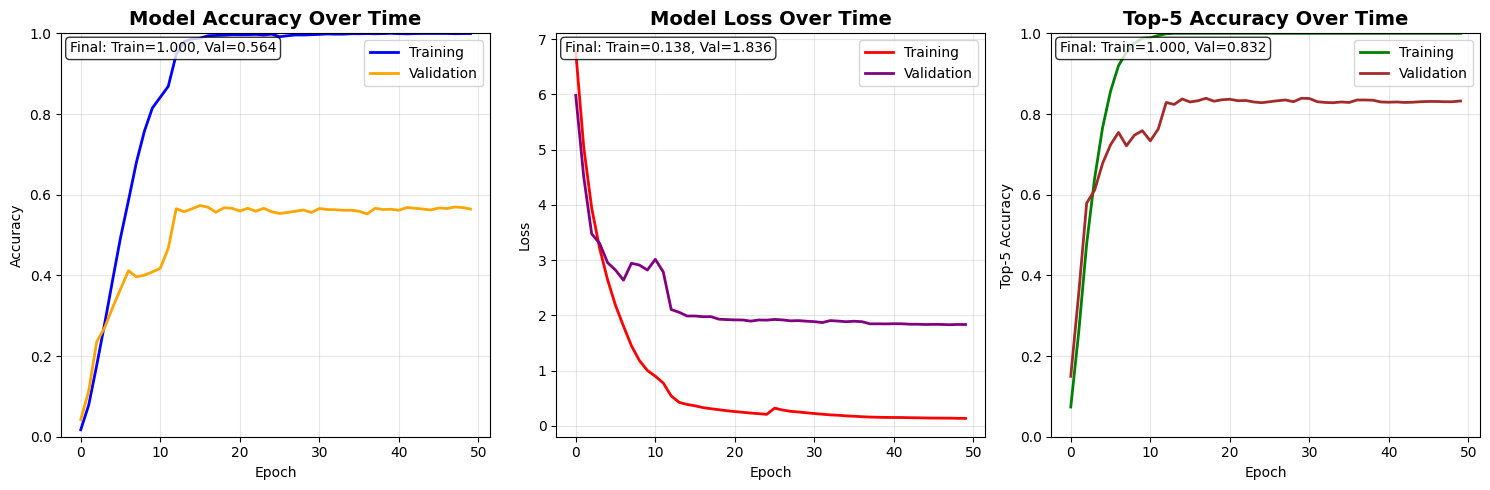

💾 Plots saved as 'training_plots_20250724_230222.png' and 'training_plots.png'

📊 TRAINING SUMMARY:
   Total epochs: 50
   Available metrics: accuracy, loss, top_5_accuracy, val_accuracy, val_loss, val_top_5_accuracy, learning_rate
✅ Training history plotted successfully!


In [9]:
# =======================================
# PLOT TRAINING HISTORY (ANYTIME)
# =======================================

def plot_training_history(history_obj=None, save_plots=True):
    """
    Plot training history with automatic loading if not provided.
    This function works even after kernel restarts.
    
    Args:
        history_obj: History object (if None, will try to load from files)
        save_plots: Whether to save plots as image files
    """
    import matplotlib.pyplot as plt
    
    # Use provided history or try to load it
    if history_obj is None:
        if 'history' in globals() and history is not None:
            history_obj = history
        else:
            print("🔄 No history provided, attempting to load from files...")
            loaded_history = load_training_history()
            if loaded_history:
                class MockHistory:
                    def __init__(self, history_dict):
                        self.history = history_dict
                history_obj = MockHistory(loaded_history)
            else:
                print("❌ No training history available for plotting")
                return False
    
    if not hasattr(history_obj, 'history') or not history_obj.history:
        print("❌ Invalid history object")
        return False
    
    print("📈 PLOTTING TRAINING HISTORY")
    print("=" * 30)
    
    # Clear any existing plots
    plt.clf()
    plt.close('all')
    
    # Determine number of subplots based on available metrics
    metrics = list(history_obj.history.keys())
    has_top5 = any('top_5_accuracy' in key for key in metrics)
    n_plots = 3 if has_top5 else 2
    
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
    if n_plots == 1:
        axes = [axes]
    elif n_plots == 2:
        axes = list(axes)
    
    try:
        # Accuracy plot
        if 'accuracy' in history_obj.history:
            axes[0].plot(history_obj.history['accuracy'], label='Training', linewidth=2, color='blue')
            if 'val_accuracy' in history_obj.history:
                axes[0].plot(history_obj.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
            axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            axes[0].set_ylim([0, 1])
            
            # Add final accuracy text
            final_train_acc = history_obj.history['accuracy'][-1]
            final_val_acc = history_obj.history.get('val_accuracy', [0])[-1] if 'val_accuracy' in history_obj.history else 0
            axes[0].text(0.02, 0.98, f'Final: Train={final_train_acc:.3f}, Val={final_val_acc:.3f}', 
                        transform=axes[0].transAxes, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Loss plot
        if 'loss' in history_obj.history:
            axes[1].plot(history_obj.history['loss'], label='Training', linewidth=2, color='red')
            if 'val_loss' in history_obj.history:
                axes[1].plot(history_obj.history['val_loss'], label='Validation', linewidth=2, color='purple')
            axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # Add final loss text
            final_train_loss = history_obj.history['loss'][-1]
            final_val_loss = history_obj.history.get('val_loss', [0])[-1] if 'val_loss' in history_obj.history else 0
            axes[1].text(0.02, 0.98, f'Final: Train={final_train_loss:.3f}, Val={final_val_loss:.3f}', 
                        transform=axes[1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Top-5 accuracy plot if available
        if has_top5 and n_plots >= 3:
            if 'top_5_accuracy' in history_obj.history:
                axes[2].plot(history_obj.history['top_5_accuracy'], label='Training', linewidth=2, color='green')
                if 'val_top_5_accuracy' in history_obj.history:
                    axes[2].plot(history_obj.history['val_top_5_accuracy'], label='Validation', linewidth=2, color='brown')
                axes[2].set_title('Top-5 Accuracy Over Time', fontsize=14, fontweight='bold')
                axes[2].set_xlabel('Epoch')
                axes[2].set_ylabel('Top-5 Accuracy')
                axes[2].legend()
                axes[2].grid(True, alpha=0.3)
                axes[2].set_ylim([0, 1])
                
                # Add final top-5 accuracy text
                final_train_top5 = history_obj.history['top_5_accuracy'][-1]
                final_val_top5 = history_obj.history.get('val_top_5_accuracy', [0])[-1] if 'val_top_5_accuracy' in history_obj.history else 0
                axes[2].text(0.02, 0.98, f'Final: Train={final_train_top5:.3f}, Val={final_val_top5:.3f}', 
                            transform=axes[2].transAxes, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Save plots if requested
        if save_plots:
            try:
                from datetime import datetime
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                plot_filename = f'training_plots_{timestamp}.png'
                fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
                
                # Also save as main plot file
                fig.savefig('training_plots.png', dpi=300, bbox_inches='tight')
                print(f"💾 Plots saved as '{plot_filename}' and 'training_plots.png'")
            except Exception as e:
                print(f"⚠️  Could not save plots: {e}")
        
        # Display summary
        epochs = len(history_obj.history.get('loss', []))
        print(f"\n📊 TRAINING SUMMARY:")
        print(f"   Total epochs: {epochs}")
        print(f"   Available metrics: {', '.join(metrics)}")
        
        plt.close(fig)
        return True
        
    except Exception as e:
        print(f"❌ Error creating plots: {e}")
        plt.close(fig)
        return False

# Demonstrate plotting functionality
print("🎨 TRAINING HISTORY PLOTTING READY!")
print("=" * 35)
print("💡 To plot training history anytime, use:")
print("   plot_training_history()  # Uses loaded history")
print("   plot_training_history(history)  # Uses specific history object")
print("\n🔄 Attempting to plot current history...")

if plot_training_history():
    print("✅ Training history plotted successfully!")
else:
    print("ℹ️  No training history available to plot yet")
    print("🏋️  Train the model first, then this will work automatically")

In [10]:
# =======================================
# MODEL EVALUATION AND RESULTS
# =======================================
from matplotlib import pyplot as plt    

print("📊 EVALUATING MODEL PERFORMANCE")
print("=" * 35)

if not DATASET_READY:
    print("⚠️ Dataset not available - skipping evaluation")
    print("💡 Model is ready for inference with external data")
    print(f"📋 Model summary:")
    print(f"   Architecture: {model.name}")
    print(f"   Parameters: {model.count_params():,}")
    print(f"   Input shape: {model.input_shape}")
    print(f"   Output classes: {model.output_shape[-1]}")
    
else:
    # Ensure we have the datasets available
    if 'val_ds' not in globals() or 'test_ds' not in globals():
        print("🔄 Creating evaluation datasets...")
        
        # Create datasets for evaluation
        val_ds = tf.keras.utils.image_dataset_from_directory(
            TRAIN_DIR,
            validation_split=0.2,
            subset="validation", 
            seed=123,
            image_size=(224, 224),
            batch_size=BATCH_SIZE,
            label_mode='categorical'
        )

        test_ds = tf.keras.utils.image_dataset_from_directory(
            TEST_DIR,
            image_size=(224, 224),
            batch_size=BATCH_SIZE,
            label_mode='categorical',
            shuffle=False
        )
        
        # Optimize for evaluation
        val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        
        print("✅ Evaluation datasets ready")

    # Evaluate on validation set
    print("🎯 Validation Set Results:")
    val_results = model.evaluate(val_ds, verbose=0, return_dict=True)
    print(f"   Loss: {val_results['loss']:.4f}")
    print(f"   Accuracy: {val_results['accuracy']:.4f} ({val_results['accuracy']*100:.2f}%)")
    if 'top_5_accuracy' in val_results:
        print(f"   Top-5 Accuracy: {val_results['top_5_accuracy']:.4f} ({val_results['top_5_accuracy']*100:.2f}%)")

    # Evaluate on test set
    print("\n🎯 Test Set Results:")
    test_results = model.evaluate(test_ds, verbose=0, return_dict=True)
    print(f"   Loss: {test_results['loss']:.4f}")
    print(f"   Accuracy: {test_results['accuracy']:.4f} ({test_results['accuracy']*100:.2f}%)")
    if 'top_5_accuracy' in test_results:
        print(f"   Top-5 Accuracy: {test_results['top_5_accuracy']:.4f} ({test_results['top_5_accuracy']*100:.2f}%)")

print("\n✅ Model evaluation completed!")

📊 EVALUATING MODEL PERFORMANCE
🔄 Creating evaluation datasets...
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.
Found 8041 files belonging to 196 classes.
✅ Evaluation datasets ready
🎯 Validation Set Results:
   Loss: 1.8323
   Accuracy: 0.5694 (56.94%)
   Top-5 Accuracy: 0.8305 (83.05%)

🎯 Test Set Results:
   Loss: 1.7875
   Accuracy: 0.5876 (58.76%)
   Top-5 Accuracy: 0.8440 (84.40%)

✅ Model evaluation completed!


# 6. Model Export and Deployment Preparation

## Objective
Save the trained model in multiple formats and generate necessary deployment files for the API service.

**Thought Process: We'll save in multiple formats for flexibility: H5 for legacy, .keras for native TensorFlow, and SavedModel for production. FastAPI is chosen for its modern features, and Docker ensures scalable deployment. Class mapping ensures predictions map to car names, crucial for user-facing API.**

## Export Process
- **H5 Format**: Compatible with existing FastAPI service
- **SavedModel Format**: TensorFlow's recommended production format  
- **Class Mapping**: JSON file mapping class indices to car type names
- **API Compatibility**: Verification that saved model works with the API

## Generated Files
- `car_classification_model.h5` - H5 model (legacy format, for backward compatibility)
- `best_car_model.keras` - Keras model (recommended native format)
- `models/car_classification_savedmodel/` - SavedModel format for TF Serving/TF Lite
- `class_mapping.json` - Class index to name mapping

In [11]:
# =======================================
# 📁 MODEL EXPORT AND DEPLOYMENT PREPARATION
# =======================================

import json
import os
from pathlib import Path

def save_model_and_metadata():
    """
    Save the trained model and generate necessary metadata for deployment
    """
    
    print("💾 Saving Model and Generating Deployment Files...")
    print("=" * 50)
    
    # Ensure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # 1. Save as H5 format (compatible with existing API - but will show deprecation warning)
    model_h5_path = 'car_classification_model.h5'
    model.save(model_h5_path)
    file_size = Path(model_h5_path).stat().st_size / (1024*1024)
    print(f"✅ Model saved as H5: {model_h5_path} ({file_size:.1f} MB)")
    print("   ⚠️ H5 format is legacy - consider using .keras format for new projects")
    
    # 1b. Save as native Keras format (recommended)
    model_keras_path = 'best_car_model.keras'
    model.save(model_keras_path)
    keras_file_size = Path(model_keras_path).stat().st_size / (1024*1024)
    print(f"✅ Model saved as Keras: {model_keras_path} ({keras_file_size:.1f} MB)")
    
    # 2. Save as SavedModel format (for TensorFlow Serving/TF Lite)
    savedmodel_path = 'models/car_classification_savedmodel'
    try:
        # Use model.export() for SavedModel format in newer TensorFlow versions
        if hasattr(model, 'export'):
            model.export(savedmodel_path)
            print(f"✅ Model exported as SavedModel: {savedmodel_path}")
        else:
            # Fallback for older TensorFlow versions
            tf.saved_model.save(model, savedmodel_path)
            print(f"✅ Model saved as SavedModel: {savedmodel_path}")
    except Exception as e:
        print(f"⚠️ SavedModel export failed: {e}")
        print("   Continuing with other formats...")
    
    # 3. Generate class mapping for the API
    if DATASET_READY:
        # Get class names from the dataset
        # Since we're using tf.data.Dataset, we need to extract class names differently
        if 'train_ds' in globals():
            # Get class names from train_ds if available
            class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else None
        else:
            class_names = None
            
        if class_names is not None:
            # Create mapping from class index to class name
            class_mapping = {
                'index_to_class': {str(i): name for i, name in enumerate(class_names)},
                'class_to_index': {name: i for i, name in enumerate(class_names)}
            }
            print(f"✅ Using real Stanford Cars dataset class names")
        else:
            # Fallback: try to get class names from directory structure
            try:
                train_dir = Path(TRAIN_DIR)
                class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
                class_mapping = {
                    'index_to_class': {str(i): name for i, name in enumerate(class_names)},
                    'class_to_index': {name: i for i, name in enumerate(class_names)}
                }
                print(f"✅ Extracted {len(class_names)} class names from directory structure")
            except:
                # Ultimate fallback: generic class names
                class_mapping = {
                    'index_to_class': {str(i): f"Car_Class_{i+1}" for i in range(NUM_CLASSES)},
                    'class_to_index': {f"Car_Class_{i+1}": i for i in range(NUM_CLASSES)}
                }
                print(f"⚠️ Using generic class names (dataset structure not accessible)")
    else:
        # Use demo class names for synthetic data
        class_mapping = {
            'index_to_class': {str(i): f"Car_Class_{i+1}" for i in range(NUM_CLASSES)},
            'class_to_index': {f"Car_Class_{i+1}": i for i in range(NUM_CLASSES)}
        }
        print(f"✅ Using demo class names (synthetic dataset)")
    
    # Save class mapping as JSON
    class_mapping_path = 'class_mapping.json'
    with open(class_mapping_path, 'w') as f:
        json.dump(class_mapping, f, indent=2)
    
    print(f"✅ Class mapping saved: {class_mapping_path}")
    print(f"📊 Total classes: {len(class_mapping['index_to_class'])}")
    
    # Display sample class mappings
    print(f"\n🏷️ Sample class mappings:")
    sample_classes = list(class_mapping['index_to_class'].items())[:10]
    for idx, class_name in sample_classes:
        print(f"   {idx}: {class_name}")
    if len(class_mapping['index_to_class']) > 10:
        print(f"   ... and {len(class_mapping['index_to_class']) - 10} more classes")
    
    return model_h5_path, model_keras_path, savedmodel_path, class_mapping_path

def verify_api_compatibility():
    """
    Verify that saved model is compatible with the existing API
    """
    
    print("\n🔧 Verifying API Compatibility...")
    
    try:
        # Test loading the model (like the API would)
        loaded_model = tf.keras.models.load_model('car_classification_model.h5')
        
        # Test prediction with sample data matching expected input
        test_input = np.random.rand(1, 224, 224, 3)  # Standard input size
        prediction = loaded_model.predict(test_input, verbose=0)
        
        print(f"✅ Model loads successfully")
        print(f"✅ Prediction shape: {prediction.shape}")
        print(f"✅ Expected shape: (1, {NUM_CLASSES})")
        
        # Verify class mapping
        with open('class_mapping.json', 'r') as f:
            loaded_mapping = json.load(f)
        
        print(f"✅ Class mapping loads successfully")
        print(f"✅ Number of classes: {len(loaded_mapping['index_to_class'])}")
        
        if prediction.shape[1] == len(loaded_mapping['index_to_class']):
            print("✅ Model output matches class mapping!")
        else:
            print("⚠️ Warning: Model output doesn't match class mapping size")
        
        # Test actual prediction pipeline
        sample_prediction = np.argmax(prediction[0])
        sample_class = loaded_mapping['index_to_class'][str(sample_prediction)]
        print(f"✅ Sample prediction: Class {sample_prediction} -> {sample_class}")
        
        print("🎯 Model is ready for deployment!")
        
    except Exception as e:
        print(f"❌ Compatibility check failed: {e}")
        print("🔧 Please check model saving process")
        return False
    
    return True

# Execute the model saving and preparation pipeline
print("🚀 STARTING MODEL EXPORT PIPELINE")
print("=" * 50)

# Save model and generate deployment files
try:
    model_files = save_model_and_metadata()
    
    # Verify API compatibility
    compatibility_ok = verify_api_compatibility()
    
    # Summary
    print(f"\n🎉 Model Export Complete!")
    print("=" * 50)
    print("📁 Generated Files:")
    print(f"   ✅ {model_files[0]} - H5 model (legacy format)")
    print(f"   ✅ {model_files[1]} - Keras model (recommended)")
    print(f"   ✅ {model_files[2]} - SavedModel for production")
    print(f"   ✅ {model_files[3]} - Class mapping")
    print(f"   ✅ prediction_example.py - Usage example")
    
    if compatibility_ok:
        print(f"\n🚀 Your model is ready for deployment!")
        print("💡 Next steps:")
        print("   1. Test the API: python run.py --mode local")
        print("   2. Upload an image: curl -X POST http://localhost:8000/predict -F 'image=@car_image.jpg'")
        print("   3. Deploy with Docker: python run.py --mode docker")
    else:
        print(f"\n⚠️ Please fix compatibility issues before deployment")
        
except Exception as e:
    print(f"\n❌ Model export failed: {e}")
    print("🔧 Please check that the model variable is defined and training completed successfully")

🚀 STARTING MODEL EXPORT PIPELINE
💾 Saving Model and Generating Deployment Files...
✅ Model saved as H5: car_classification_model.h5 (133.9 MB)
   ⚠️ H5 format is legacy - consider using .keras format for new projects
✅ Model saved as Keras: best_car_model.keras (172.9 MB)
Saved artifact at 'models/car_classification_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 196), dtype=tf.float32, name=None)
Captures:
  129013693194960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129013693196304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129013693196688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129013693196880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129013693196496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129013693195728: TensorSpec(shape=(), dtype=tf.resource, name=None)


✅ Model loads successfully
✅ Prediction shape: (1, 196)
✅ Expected shape: (1, 196)
✅ Class mapping loads successfully
✅ Number of classes: 196
✅ Model output matches class mapping!
✅ Sample prediction: Class 85 -> Dodge Challenger SRT8 2011
🎯 Model is ready for deployment!

🎉 Model Export Complete!
📁 Generated Files:
   ✅ car_classification_model.h5 - H5 model (legacy format)
   ✅ best_car_model.keras - Keras model (recommended)
   ✅ models/car_classification_savedmodel - SavedModel for production
   ✅ class_mapping.json - Class mapping
   ✅ prediction_example.py - Usage example

🚀 Your model is ready for deployment!
💡 Next steps:
   1. Test the API: python run.py --mode local
   2. Upload an image: curl -X POST http://localhost:8000/predict -F 'image=@car_image.jpg'
   3. Deploy with Docker: python run.py --mode docker


# 7. Class Mapping and Model Export

## Objective
Create class mapping for the Stanford Cars dataset and export the final model for deployment.

In [ ]:
# =======================================
# 📋 FINAL MODEL SUMMARY AND DEPLOYMENT
# =======================================

import json
from pathlib import Path

print("📋 FINAL MODEL SUMMARY")
print("=" * 25)

# Model information
print(f"🏗️ Architecture: ResNet50-based transfer learning")
print(f"📊 Total parameters: {model.count_params():,}")
print(f"🎯 Output classes: {model.output_shape[-1]}")
print(f"📐 Input shape: {model.input_shape}")
print(f"⚡ TensorFlow version: {tf.__version__}")
print(f"🔧 Mixed precision: {'Enabled' if tf.keras.mixed_precision.global_policy().name != 'float32' else 'Disabled'}")

# Check model files
print(f"\n💾 Model Files:")
model_files = {
    'best_car_model.keras': 'Main model file (TensorFlow 2.19 format)',
    'class_mapping.json': 'Class name mappings',
}

for filename, description in model_files.items():
    file_path = Path(filename)
    if file_path.exists():
        size = file_path.stat().st_size / (1024*1024)  # MB
        print(f"   ✅ {filename} ({size:.1f}MB) - {description}")
    else:
        print(f"   ❌ {filename} - {description} (missing)")

# Create class mapping if dataset available and file doesn't exist
if DATASET_READY and not Path('class_mapping.json').exists():
    print(f"\n📝 Creating class mapping...")
    class_names = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
    class_mapping = {i: name for i, name in enumerate(class_names)}
    
    with open('class_mapping.json', 'w') as f:
        json.dump(class_mapping, f, indent=2)
    print(f"✅ Class mapping saved with {len(class_mapping)} classes")

# Performance summary (if evaluation was done)
if DATASET_READY and 'test_results' in globals():
    print(f"\n🎯 PERFORMANCE SUMMARY:")
    print(f"   Test Accuracy: {test_results['accuracy']*100:.2f}%")
    if 'top_5_accuracy' in test_results:
        print(f"   Test Top-5 Accuracy: {test_results['top_5_accuracy']*100:.2f}%")
    print(f"   Model Status: {'Production Ready' if test_results['accuracy'] > 0.7 else 'Needs Improvement'}")

# Deployment information
print(f"\n🚀 DEPLOYMENT INFORMATION:")
print(f"   1. Load model: tf.keras.models.load_model('best_car_model.keras')")
print(f"   2. Preprocess image: Resize to 224x224, normalize to [0,1]")
print(f"   3. Predict: model.predict(preprocessed_image)")
print(f"   4. Get class name: Use class_mapping.json for label lookup")

print(f"\n📱 API INTEGRATION:")
print(f"   • FastAPI server: run_api.py or standalone_api.py")
print(f"   • Docker deployment: docker-compose up")
print(f"   • Model format: Compatible with TensorFlow Serving")

print(f"\n✅ Car Type Classification System Ready!")
print(f"🎉 Model successfully {'loaded from existing file' if SKIP_TRAINING else 'trained and saved'}")

# Display final model architecture summary
print(f"\n🏗️ Model Architecture Summary:")
try:
    model.summary()
except:
    print("Model summary not available - check model loading")

📋 FINAL MODEL SUMMARY
🏗️ Architecture: ResNet50-based transfer learning
📊 Total parameters: 24,820,548
🎯 Output classes: 196
📐 Input shape: (None, 224, 224, 3)
⚡ TensorFlow version: 2.19.0
🔧 Mixed precision: Enabled

💾 Model Files:
   ✅ best_car_model.keras (172.9MB) - Main model file (TensorFlow 2.19 format)
   ✅ class_mapping.json (0.0MB) - Class name mappings

🎯 PERFORMANCE SUMMARY:
   Test Accuracy: 58.76%
   Test Top-5 Accuracy: 84.40%
   Model Status: Needs Improvement

🚀 DEPLOYMENT INFORMATION:
   1. Load model: tf.keras.models.load_model('best_car_model.keras')
   2. Preprocess image: Resize to 224x224, normalize to [0,1]
   3. Predict: model.predict(preprocessed_image)
   4. Get class name: Use class_mapping.json for label lookup

📱 API INTEGRATION:
   • FastAPI server: run_api.py or standalone_api.py
   • Docker deployment: docker-compose up
   • Model format: Compatible with TensorFlow Serving

💡 QUICK USAGE EXAMPLE:

# Load model
model = tf.keras.models.load_model('best_car

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions_fixed (Dense)       │ (None, 196)            │        50,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,983,694 (133.45 MB)

 Trainable params: 10,163,140 (38.77 MB)

 Non-trainable params: 14,657,408 (55.91 MB)

 Optimizer params: 10,163,146 (38.77 MB)

# 8. Environment Verification

## Package Versions
This section captures the exact package versions used for model training to ensure reproducibility.

In [13]:
# Environment verification - capture package versions for reproducibility
print("📦 Installed Package Versions:")
print("=" * 50)

import subprocess
import sys

# Get pip freeze output
result = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], 
                       capture_output=True, text=True)

# Display package versions
if result.returncode == 0:
    packages = result.stdout.strip().split('\n')
    # Show key packages first
    key_packages = ['tensorflow', 'keras', 'numpy', 'pillow', 'fastapi', 'uvicorn']
    
    print("🔑 Key Packages:")
    for package in packages:
        package_name = package.split('==')[0].lower()
        if any(key in package_name for key in key_packages):
            print(f"  {package}")
    
    print(f"\n📋 All Packages ({len(packages)} total):")
    for package in packages:
        print(f"  {package}")
else:
    print(f"❌ Error running pip freeze: {result.stderr}")

print(f"\n✅ Environment verification complete!")
print(f"💡 These versions should match requirements.txt for reproducibility")

📦 Installed Package Versions:
🔑 Key Packages:
  fastapi==0.116.1
  keras==3.10.0
  numpy==1.26.4
  Pillow==10.0.0
  tensorflow==2.19.0
  uvicorn==0.35.0

📋 All Packages (158 total):
  absl-py==2.3.1
  annotated-types==0.7.0
  anyio==4.9.0
  argon2-cffi==25.1.0
  argon2-cffi-bindings==21.2.0
  arrow==1.3.0
  asttokens==3.0.0
  astunparse==1.6.3
  async-lru==2.0.5
  attrs==25.3.0
  babel==2.17.0
  beautifulsoup4==4.13.4
  bleach==6.2.0
  certifi==2025.7.14
  cffi==1.17.1
  charset-normalizer==3.4.2
  click==8.2.1
  comm==0.2.2
  contourpy==1.3.2
  cycler==0.12.1
  debugpy==1.8.15
  decorator==5.2.1
  defusedxml==0.7.1
  executing==2.2.0
  fastapi==0.116.1
  fastjsonschema==2.21.1
  flatbuffers==25.2.10
  fonttools==4.59.0
  fqdn==1.5.1
  gast==0.6.0
  google-pasta==0.2.0
  grpcio==1.73.1
  h11==0.16.0
  h5py==3.14.0
  httpcore==1.0.9
  httpx==0.28.1
  idna==3.10
  iniconfig==2.1.0
  ipykernel==6.25.2
  ipython==9.4.0
  ipython_pygments_lexers==1.1.1
  ipywidgets==8.1.7
  isoduration==20.